In [12]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import seaborn as sns

# Error correction on an analog compute-in-memory array using SVMs
Assuming we have a compute-in-memory array with weight matrix $W$.<br>
For an input vector $x^i \in \mathcal{X}$, we can read $y^i = f(W x^i)$ with $y^i\approx\hat y^i \in \mathcal{Y}$, where $\mathcal{X}\subseteq \mathbb{R}^n$ is a (fixed) set of test-vectors and $\mathcal{Y}\subseteq \mathbb{N}$ is a discrete set of labels.


Now assume that W degrades over time, e.g. $W(t) = W(0) + U(t) + \varepsilon(t)$, where $\varepsilon(t)$ is a noise process and $U(t)$ is user provided input.
We want to make sure that $U$ compensates for the noise, such that $y(t)$ doesn't change.

$f(W(\Delta t)x) = f((W(0) + U(\Delta t) + \varepsilon(\Delta t))x) \stackrel{!}{=} f(W(0)x)$

## General idea for maximum margin-based solution

* take (random? evenly-spaced?) vectors $x^0, x^1, ... \in \{0,1\}^N$ as inputs
* compute $y^i = W x^i$, where $W \in \mathbb{R}^N$ is the analog weight matrix
* for each $y^i_j$:
    * see if it is safely classified as $0$ or $1$, i.e. $y^i_j \not\in [0,1]$, in which case nothing needs to be done
    * otherwise, if $y^i_j \in [0,0.5]$, update towards $0$, i.e. push weight vector column **away from** $x^i$
    * otherwise, if $y^i_j \in (0.5,1.0]$, update towards $1$, i.e. push weight vector column **towards** $x^i$

In [13]:
class MultiClassClassifier(object):
    """
    A abstract multi-class classifier base-class.
    """

    def train(self, data: np.ndarray, labels: np.ndarray):
        """
        Train the classifier on the provided data and labels.

        Args:
            data (np.ndarray): The input data to train the classifier on.
            labels (np.ndarray): The labels for the input data.
        """
        pass

    def predict(self, data: np.ndarray):
        """
        Predict the labels for the provided data.

        Args:
            data (np.ndarray): The input data to predict the labels for.

        Returns:
            np.ndarray: The predicted labels.
        """
        pass


class LinearMultiClassSVM(MultiClassClassifier):
    """
    A linear multi-class SVM classifier.
    """

    def __init__(
        self,
        data: np.ndarray = None,
        labels: np.ndarray = None,
        initial_params: np.ndarray = None,
        n_dims_in: int = None,
        n_dims_out: int = None,
        target_label: int = None,
    ):
        """
        Initialize the classifier with the provided dimensions.

        Args:
            data (np.ndarray): The input data to train the classifier on.
            labels (np.ndarray): The labels for the input data.
            initial_params (np.ndarray): The initial parameters for the classifier.
            n_dims_in (int): The number of input dimensions.
            n_dims_out (int): The number of output dimensions.
        """

        # either data or n_dims_in must be provided
        assert (
            data is not None or n_dims_in is not None
        ), "Either data or n_dims_in must be provided"

        # either labels or n_dims_out must be provided
        assert (
            labels is not None or n_dims_out is not None
        ), "Either labels or n_dims_out must be provided"

        # if the target label is not provided, use the first label (then, labels must be provided)
        if target_label is None:
            assert labels is not None, "Labels must be provided if target_label is not provided."
            target_label = labels[0]
        self.target_label = target_label

        if n_dims_in is None:
            n_dims_in = data.shape[1]

        if n_dims_out is None:
            n_dims_out = len(np.unique(labels))

        self.n_dims_out = n_dims_out
        self.n_dims_in = n_dims_in

        # either both data and labels must be provided or neither
        assert (
            data is not None and labels is not None
        ) or (
            data is None and labels is None
        ), "Either both data and labels must be provided or neither."

        # dimensions of the data and labels must match
        if data is not None and labels is not None:
            assert (
                data.shape[0] == len(labels) and data.shape[1] == n_dims_in and n_dims_out == len(np.unique(labels))
            ), f"Dimensions of the data {data.shape} and labels {labels.shape} do not match the provided dimensions {(n_dims_in, n_dims_out)}."

        if initial_params is None:
            self.params = np.random.randn(n_dims_out, n_dims_in + 1)
        else:
            # check if the initial_params are of the correct shape
            assert initial_params.shape == (
                n_dims_out,
                n_dims_in + 1,
            ), f"Initial params must be of shape ({n_dims_out},{n_dims_in + 1})"

            self.params = initial_params.copy()


    def train(self, data: np.ndarray, labels: np.ndarray):
        """
        Train the classifier on the provided data and labels.

        Args:
            data (np.ndarray): The input data to train the classifier on.
            labels (np.ndarray): The labels for the input data.
        """
        pass

    def _get_w_b(self):
        return self.params[...,:-1], self.params[...,-1][..., :, np.newaxis]

    def gradient_step(self, data: np.ndarray, labels: np.ndarray, lam=1e-3, learning_rate=0.1):
        # calculate the scores (affine transformation)
        # max(0, 1 - y*(w^T x_i - b))
        w, b = self._get_w_b()
        y = (labels==self.target_label)*2-1

        # compute loss
        pred = self.predict(data, linear=True)
        score = 1.0 - y * pred 
        loss = lam*np.linalg.norm(w, axis=-1) + lam*b**2 + np.mean(np.maximum(0.0, score), axis=-1)

        # compute gradients
        grad_w = lam * 2 * w + np.mean(np.where(score > 0, -y*np.swapaxes(data, -1, -2), 0.0), axis=-1)
        grad_b = lam * 2 * b[...,0] + np.mean(np.where(score > 0, y, 0.0), axis=-1)

        # # calculate the margins
        # margins = scores - scores[labels, np.arange(len(labels))] + 1

        # # set the margins of the correct class to zero
        # margins[labels, np.arange(len(labels))] = 0

        # # calculate the loss
        # loss = np.sum(np.maximum(0, margins))

        # # calculate the gradient of the loss
        # grad = np.zeros_like(self.params)
        # grad[margins > 0] = 1
        # grad[labels, np.arange(len(labels))] = -np.sum(grad, axis=0)

        # update the parameters
        self.params[...,:-1] -= learning_rate * grad_w
        self.params[...,-1] -= learning_rate * grad_b

        return loss

    def predict(self, data: np.ndarray, linear=False):
        """
        Predict the labels for the provided data.

        Args:
            data (np.ndarray): The input data to predict the labels for.

        Returns:
            np.ndarray: The predicted labels.
        """
        w, b = self._get_w_b()

        # calculate the scores (affine transformation)

        lin = np.dot(w, np.swapaxes(data, -1, -2)) - b

        if linear:
            return lin
        else:
            return np.where(lin>0, 1, -1)


In [14]:
def perturb_memory(params, dt, decay: float = 1.0, noise: float = 0.1):
    """
    Perturb the memory by adding noise to the parameters.

    Args:
        params (np.ndarray): The parameters of the memory.
        decay (float): The decay factor for the perturbation.
        noise (float): The noise level for the perturbation.

    Returns:
        np.ndarray: The perturbed parameters.
    """
    return params * np.exp(-decay*dt) + noise * np.random.randn(*params.shape) * np.sqrt(dt)

## Minimal example

In [15]:
from typing import Tuple
import pandas as pd

def plot_frame(
    data: pd.DataFrame, 
    parameters: np.ndarray,
    O: np.ndarray = np.array([0.0, 0.0]),
) -> Tuple[plt.Figure, plt.Axes, dict[str, object]]:
    fig, ax = plt.subplots()

    ax.set_aspect(1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    sns.scatterplot(data, x="x", y="y", hue="class", ax=ax)

    pred_pos = ax.scatter(data["x"], data["y"], facecolors=["none" for i in range(len(data))], edgecolors=["black" for i in range(len(data))], marker="o", alpha=np.zeros(len(data)))
    pred_neg = ax.scatter(data["x"], data["y"], color=["black" for i in range(len(data))], marker="x", alpha=np.zeros(len(data)))

    # find orthogonal line
    dir = np.array([parameters[1], -parameters[0]])
    dir /= np.linalg.norm(dir)
    w_normed = parameters / np.linalg.norm(parameters) ** 2
    O_prime = O + w_normed
    pts = np.stack([O_prime + 3 * dir, O_prime - 3 * dir])

    line = ax.plot(pts[:,0], pts[:,1], linestyle="dashed", color="black")[0]
    arrow = ax.arrow(
        *O,
        *w_normed,
        head_width=0.05,
        fc="black",
        ec="black",
        length_includes_head=True
    )

    ax.scatter([O[0]], [O[1]], color="black", marker="x")

    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])

    return fig, ax, {
        "points": ax.collections[0],
        "pred_pos": pred_pos,
        "pred_neg": pred_neg,
        "line": line, 
        "arrow": arrow
    }


def update_frame(
        data: pd.DataFrame, 
        parameters: np.ndarray, 
        fig: plt.Figure,
        ax: plt.Axes, 
        plots: dict[str, object],
        O: np.ndarray = np.array([0.0, 0.0]),
        highlight_frame: str = None
    ):
    # update the classifier
    # classifier = LinearMultiClassSVM(initial_params=parameters)
    # memory = ConsolidatingMemory(classifier, data[["x", "y"]].values, data["class"].values)

    # consolidate the memory
    # memory.consolidate(n_samples=100)

    # find orthogonal line
    dir = np.array([parameters[1], -parameters[0]])
    dir /= np.linalg.norm(dir)
    w_normed = parameters / np.linalg.norm(parameters) ** 2
    O_prime = O + w_normed
    pts = np.stack([O_prime + 3 * dir, O_prime - 3 * dir])
    

    # update the plots
    plots["points"].set_offsets(data[["x", "y"]].values)
    # plots["points"].set_array(data["class"].values)
    cmap = sns.color_palette()
    plots["points"].set_color([cmap[c] for c in data["class"].values])

    # for all points where the prediction is positive, make marker visible
    plots["pred_pos"].set_facecolors(["none" for i in range(len(data))])
    plots["pred_pos"].set_alpha(data["predicted"] == 1)
    # for all points where the prediction is negative, make marker visible
    plots["pred_neg"].set_alpha(data["predicted"] == -1)

    # update the line
    plots["line"].set_data(pts[:,0], pts[:,1])

    # redraw the arrow
    plots["arrow"].remove()
    plots["arrow"] = ax.arrow(
        *O,
        *w_normed,
        head_width=0.05,
        fc="black",
        ec="black",
        length_includes_head=True
    )

    if highlight_frame is not None:
        ax.patch.set_edgecolor(highlight_frame)  
        ax.patch.set_linewidth(10)
    else:
        ax.patch.set_edgecolor('black')  
        ax.patch.set_linewidth(0)

    return fig, ax, plots


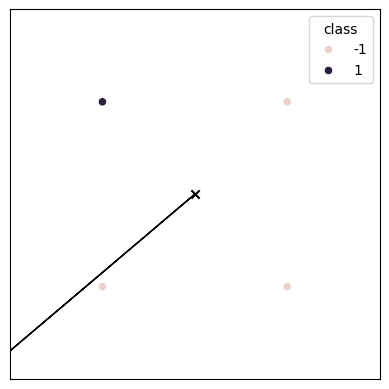

In [16]:
x = np.array([[-0.5, -0.5], [0.5, -0.5], [0.5, 0.5], [-0.5, 0.5]])
y = np.array([-1, -1, -1, 1])

data = pd.DataFrame({"x": x[:, 0], "y": x[:, 1], "class": y, "predicted": y})


svm = LinearMultiClassSVM(data[["x", "y"]].values, data["class"].values, target_label=1)
data["predicted"] = svm.predict(data[["x", "y"]].values)[0]
w, b = svm._get_w_b()
fig, ax, plots = plot_frame(data, w[0] / b[0])

[[0.56777855 1.05104943]
 [0.55792635 1.04119722]]


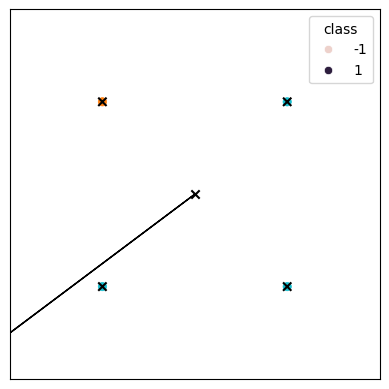

In [17]:
loss = svm.gradient_step(data[["x", "y"]].values, data["class"].values, lam=1e-2, learning_rate=1e-1)
data["predicted"] = svm.predict(data[["x", "y"]].values)[0]
w, b = svm._get_w_b()
update_frame(data, w[0] / b[0], fig, ax, plots, highlight_frame=None)
print(loss)
fig

In [18]:
svm.params[...,-1]

array([ 0.99219479, -0.00627634])

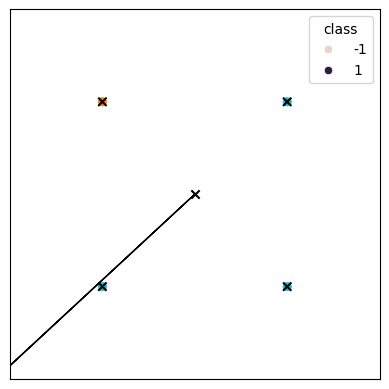

In [19]:
svm.params[...,:-1] = perturb_memory(svm.params[...,:-1], 1e-3, noise=2.0)
data["predicted"] = svm.predict(data[["x", "y"]].values)[0]
w, b = svm._get_w_b()
update_frame(data, w[0] / b[0], fig, ax, plots)
# print(loss)
fig

In [20]:
dt = 1e-3
def animate_frames(frame: int, dt: float = 1e-3, cycles=5, pbar=None, lam=1e-3, decay=0.1, noise=0.1, periods = 2.0, consolidate: bool = True):
    global svm
    # every 10 seconds, reinitialize

    if frame % int((cycles*periods)/dt) == 0:
        # randomize the classes
        data["class"] = np.array([
            [-1,-1,-1,-1],
            [ 1, 1, 1, 1],
            [-1,-1,-1, 1],
            [-1,-1, 1,-1],
            [-1, 1,-1,-1],
            [ 1,-1,-1,-1],
            [-1,-1, 1, 1],
            [-1, 1, 1,-1],
            [ 1, 1,-1,-1],
            [ 1,-1,-1, 1],
            [ 1, 1, 1,-1],
            [ 1, 1,-1, 1],
            [ 1,-1, 1, 1],
            [-1, 1, 1, 1],
        ])[np.random.randint(0, 14)]


    # perturb the memory
    highlight = None
    svm.params[...,:-1] = perturb_memory(svm.params[...,:-1], dt, decay=decay, noise=noise)
    data["predicted"] = svm.predict(data[["x", "y"]].values)[0]

    # for 1 second train, then alternate between nothing and consolidation
    if ((frame * dt) % (cycles*periods)) < periods:
        # train the classifier for a couple of steps on the real data
        loss = svm.gradient_step(data[["x", "y"]].values, data["class"].values, lam=1e-3, learning_rate=1e-1)
        highlight = "red"
    elif consolidate and ((frame * dt) % (2*periods)) < periods:
        # consolidate the memory

        # take the imputed labels to update
        loss = svm.gradient_step(data[["x", "y"]].values, data["predicted"].values, lam=1e-3, learning_rate=1e-1)
        # print(loss)
        highlight = "green"
    
    w, b = svm._get_w_b()
    update_frame(data, w[0] / b[0], fig, ax, plots, highlight_frame=highlight)

    if pbar is not None:
        pbar.update(frame)

    return list(plots.values())

In [21]:
from functools import partial
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm

duration = 60_000 #ms
interval = 10 #ms
dt = 1e-3 # timestep = 1ms
# pbar = tqdm(int(duration/interval))
pbar = None
anim = animation.FuncAnimation(fig, partial(animate_frames, dt=interval*dt, cycles=6, lam=1e-4, noise=0.05, decay=0.05, periods=10.0, pbar=pbar, consolidate=True), frames=int(duration/interval), interval=interval, blit=True)
HTML(anim.to_html5_video())

In [22]:
anim = animation.FuncAnimation(fig, partial(animate_frames, dt=interval*dt, pbar=pbar, consolidate=False), frames=int(duration/interval), interval=interval, blit=True)
HTML(anim.to_html5_video())